# Investigating seasonal patterns for sensor reading occurrences

## 1. Overview
The analysis in this notebook aims to investigate seasonal patterns on sensor reading occurrences.
The notebook is divided as follows:

* **section 2 - Notebook preparation** shows how the environment was prepared such as loading packages, reading data and checking data pre-conditions

* **section 3 - Event occurrence distribution** contains some analysis about how the data is distributed in different perspectives

* **section 4 - Conclusions** summarizes the findings from the data and how to use them as a next step



## 2. Notebook preparation
### 2.1 Load packages

In [1]:
if (!require("purrr")) { install.packages("purrr", lib='/R/library', repos='http://cran.us.r-project.org') }
if (!require("tidyr")) { install.packages("tidyr", lib='/R/library', repos='http://cran.us.r-project.org') }
if (!require("dplyr")) { install.packages("dplyr", lib='/R/library', repos='http://cran.us.r-project.org') }
if (!require("ggplot2")) { install.packages("ggplot2", lib='/R/library', repos='http://cran.us.r-project.org') }
if (!require("lubridate")) { install.packages("lubridate", lib='/R/library', repos='http://cran.us.r-project.org') }


Loading required package: purrr
Loading required package: tidyr
Loading required package: dplyr

Attaching package: ‘dplyr’

The following object is masked from ‘package:purrr’:

    order_by

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2
Loading required package: lubridate

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



### 2.2 Reading data
This data represents 6 months of sensor data from several printers considering only the event SAMPLE_PIP_AND_IMO_PARAMETERS.

The data is loaded from file 'Indigo.dat' which a tidy version of the file 'Book1.xls' sent by Indigo Team for analysis.

Column dt_event_date is event_date converted to date time and column event_press was converted to string so to make it faster than string column event_date and press number converted to string to prevent scientific long integer visualization (e.g. 134e-14).

In [82]:
load('IndigoData.dat')
data$dt_event_date = as.POSIXct(data$event_date)
data$event_press = as.character(data$event_press)
glimpse(data)

Observations: 1,211,693
Variables: 23
$ event_RowNumber (dbl) 15765585098, 15765585142, 15765585284, 15765585445,...
$ event_press     (chr) "45000586", "45000586", "45000586", "45000586", "45...
$ Product_Line    (fctr) HP Indigo 7600, HP Indigo 7600, HP Indigo 7600, HP...
$ series          (fctr) 7000 Family Sheet Fed Commercial Press, 7000 Famil...
$ Region          (fctr) North America, North America, North America, North...
$ SubRegion       (fctr) MidAtlantic United States, MidAtlantic United Stat...
$ District        (fctr) UNITED STATES, UNITED STATES, UNITED STATES, UNITE...
$ Ownership       (fctr) DIRECT, DIRECT, DIRECT, DIRECT, DIRECT, DIRECT, DI...
$ event_recNum    (int) 739828, 739878, 740037, 740221, 740224, 740554, 740...
$ event_date      (chr) "2016-06-08 00:00:00.000", "2016-06-08 00:00:00.000...
$ event_time      (int) 74703, 75903, 84709, 93603, 95930, 120644, 132213, ...
$ event_name      (fctr) SAMPLE_PIP_AND_IMO_PARAMETERS, SAMPLE_PIP_AND_IMO_...
$ event_state 

### 2.3 Checking data pre-conditions
Checking if all printers events are SAMPLE_PIP_AND_IMO_PARAMETERS.

In [3]:
data %>% dplyr::summarize(Count = n()) 

,Count
1,1211693


In [4]:
data %>% filter(event_name == "SAMPLE_PIP_AND_IMO_PARAMETERS") %>% dplyr::summarise(Count = n())

,Count
1,1211693


Number of rows is the same for both data what confirms that only events SAMPLE_PIP_AND_IMO_PARAMETERS are being considered.

## 3. Events occurrence distribution
Printers event occurrences vary from one day to another. Are there any patterns in this distribution ?
### 3.1 Daily events median considering all printers separating weekdays from weekends
In order to have a broad overview of the event occurrences, first the average of daily event occurrences is calculated considering all printers regardless of state, district or product line.
This can be seen from the data frame below:

In [11]:
daily_freq_week_day <- data %>% 
    mutate(total_printers = n_distinct(event_press)) %>%    
    group_by(dt_event_date) %>%
    dplyr::summarise(Median=n()/first(total_printers)) %>%
    mutate(day_type = (wday(dt_event_date) == 1 | wday(dt_event_date) == 7) ) %>%
    mutate(day_type = sapply(day_type, function(is_weekend) { ifelse(is_weekend,"weekend","weekday") }))
glimpse(daily_freq_week_day)

Observations: 182
Variables: 3
$ dt_event_date (time) 2016-01-01, 2016-01-02, 2016-01-03, 2016-01-04, 2016...
$ Median        (dbl) 0.2130584, 1.1786942, 1.9770905, 10.1970218, 9.964490...
$ day_type      (chr) "weekday", "weekend", "weekend", "weekday", "weekday"...


The data frame above shows that the average event occurrence varies greatly from one day to another.
Note that the event date was labeled as weekday or weekend as shown in column day_type.

For better visualization a plot to represent those two event occurrence types was created as two lines. 
One line for weekdays event occurrences (red line) and another for weekends (green line).

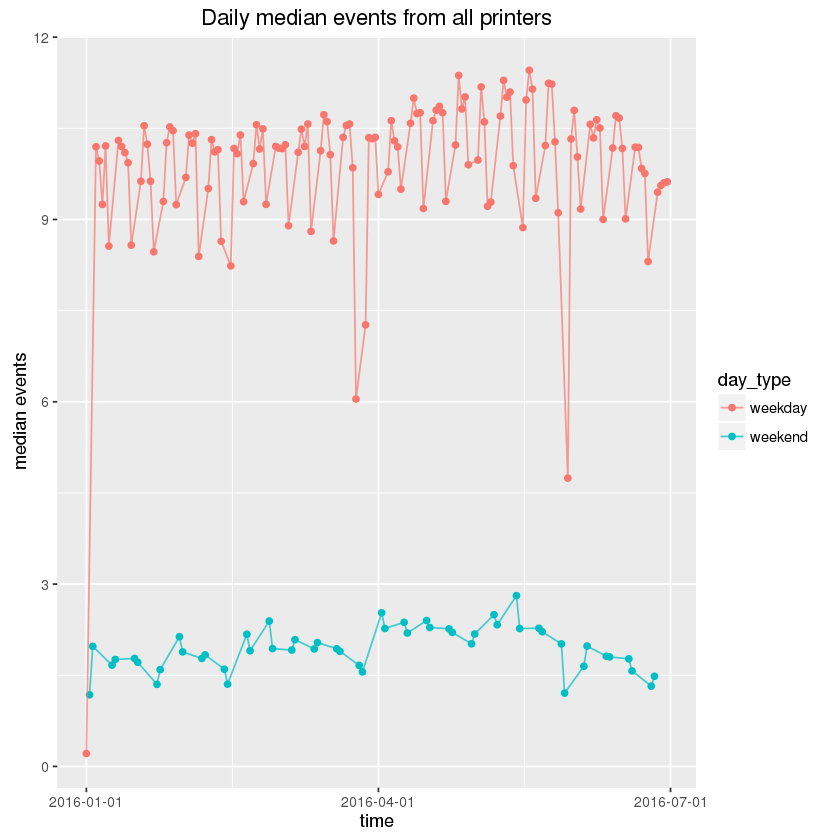

In [12]:
ggplot(daily_freq_week_day, aes(x=dt_event_date, y=Median, col = day_type)) +
        ggtitle("Daily median events from all printers") +
        scale_x_datetime(date_labels='%Y-%m-%d') +
        xlab("time") + 
        ylab("median events") +
        geom_point() +
        geom_line(alpha = 0.7) 

The diagram above shows a clear separation in the event frequency during weekdays compared to weekend days. 
Are there any other interesting seasonal patterns ?

### 3.2 Histogram of events occurrences considering all printers in PRINT_STATE
The next diagram shows the histogram of evetns along the weekdays.

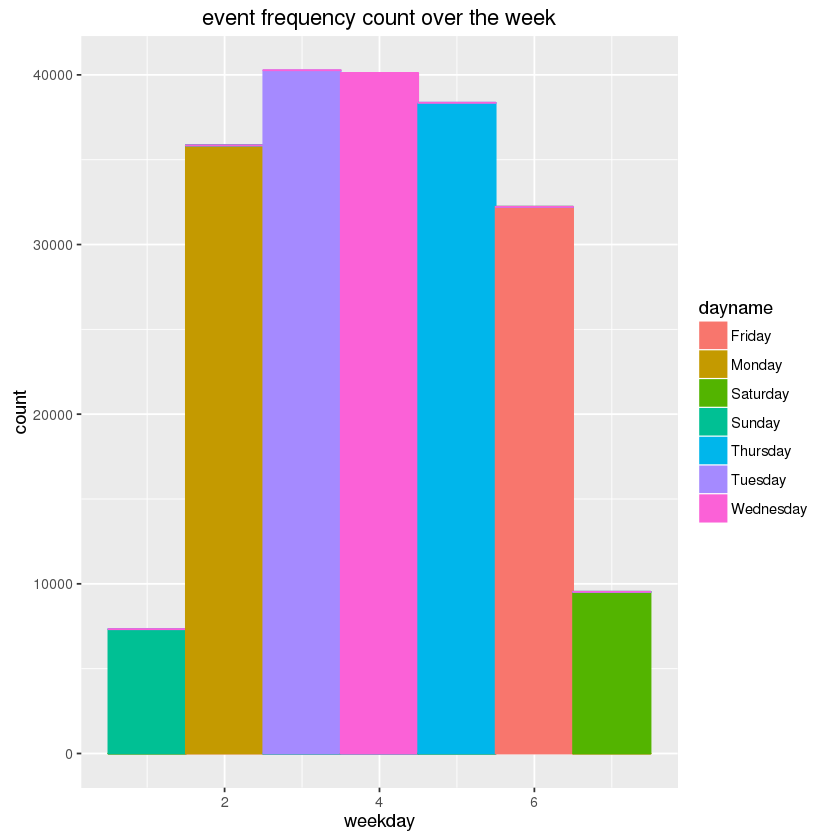

In [81]:
data %>% 
    filter(event_state == "PRINT_STATE") %>%
    mutate(weekday = wday(dt_event_date), dayname = weekdays(dt_event_date)) %>%
    ggplot(aes(x=weekday, y=..count.., col=dayname, fill=dayname)) +
    geom_histogram(bins = 7) +
    ggtitle("event frequency count over the week")

Considering only weekdays, the histogram above shows that Monday and Friday are days with less occurrence of printer events. Weekend days continue to have much lower frequency compared to weekdays as shown in the previous plot.

Will this seasonal pattern continue to exist considering different product lines, districts, firmware versions and printer states ? 

The next diagrams in subsection 3.3, 3.4, 3.5 and 3.6 try to answer this question.

### 3.3 Histogram of events occurrences considering all printers in PRINT_STATE grouped by product line
Next a histogram of event occurrence shows the distribution per product line.

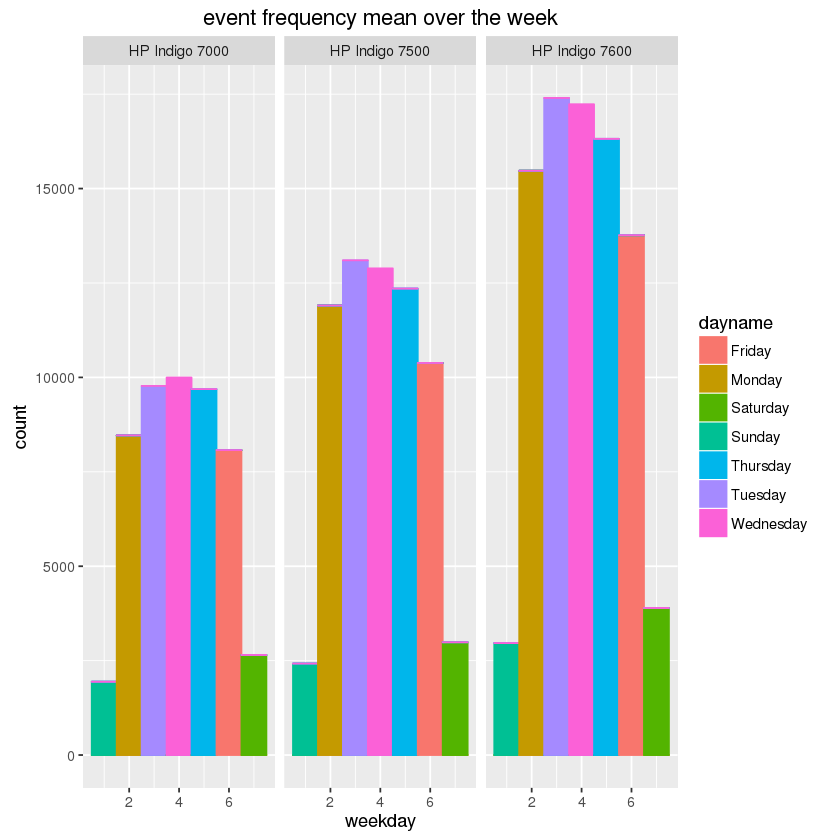

In [39]:
data %>% 
    filter(event_state == "PRINT_STATE") %>%
    mutate(weekday = wday(dt_event_date), dayname = weekdays(dt_event_date)) %>%
    ggplot(aes(x=weekday, y=..count.., col=dayname, fill=dayname)) +
    geom_histogram(bins = 7) +
    ggtitle("event frequency mean over the week") + 
    facet_wrap(~ Product_Line)

Plot shows similar distribution pattern among product lines.
### 3.4 Histogram of events occurrences considering all printers in PRINT_STATE grouped by district

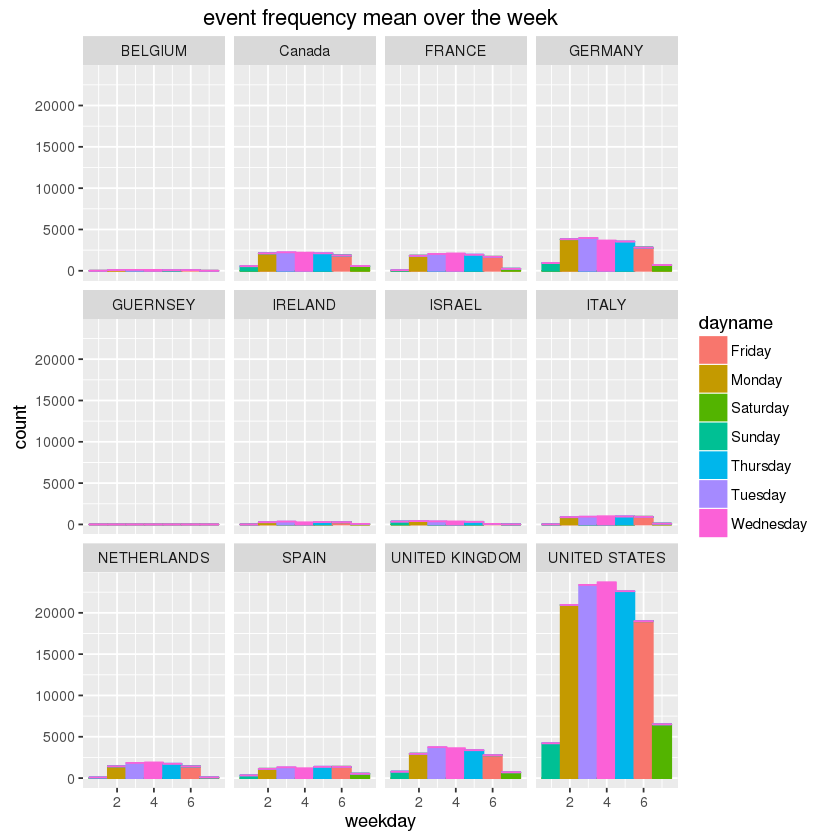

In [40]:
data %>% 
    filter(event_state == "PRINT_STATE") %>%
    mutate(weekday = wday(dt_event_date), dayname = weekdays(dt_event_date)) %>%
    ggplot(aes(x=weekday, y=..count.., col=dayname, fill=dayname)) +
    geom_histogram(bins = 7) +
    ggtitle("event frequency mean over the week") + 
    facet_wrap(~ District)

Plot shows similar distribution pattern among different districts (countries).
### 3.5 Histogram of events occurrences considering all printers in PRINT_STATE grouped by firmware version

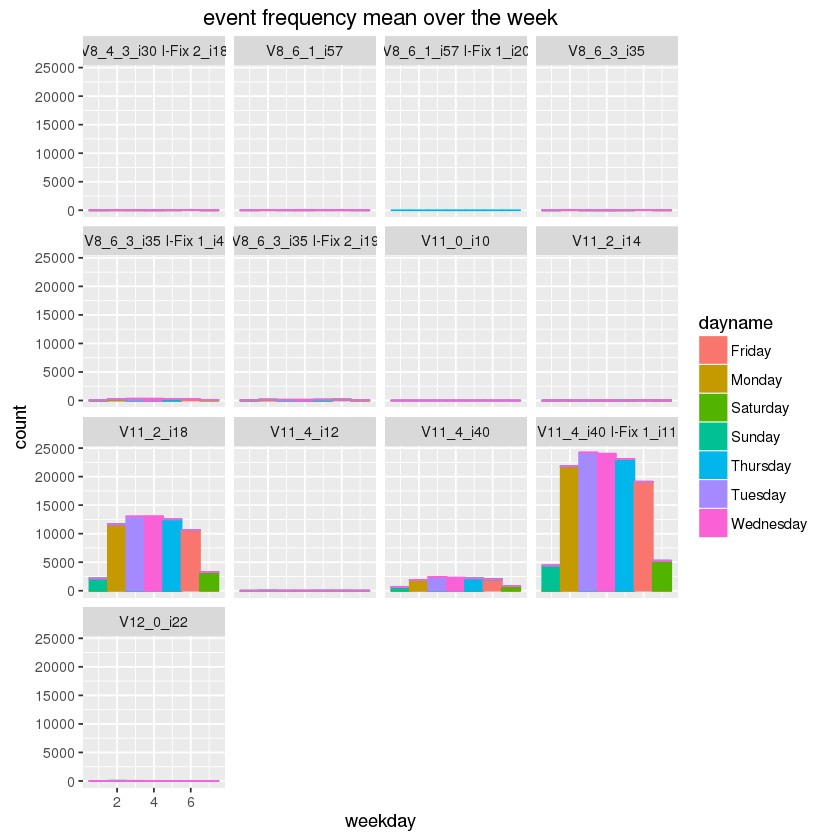

In [42]:
data %>% 
    filter(event_state == "PRINT_STATE") %>%
    mutate(weekday = wday(dt_event_date), dayname = weekdays(dt_event_date)) %>%
    ggplot(aes(x=weekday, y=..count.., col=dayname, fill=dayname)) +
    geom_histogram(bins = 7) +
    ggtitle("event frequency mean over the week") + 
    facet_wrap(~ SWv)

Plot shows similar distribution pattern considering different firmware versions.
### 3.6 Histogram of events occurrences considering all printers grouped by print state

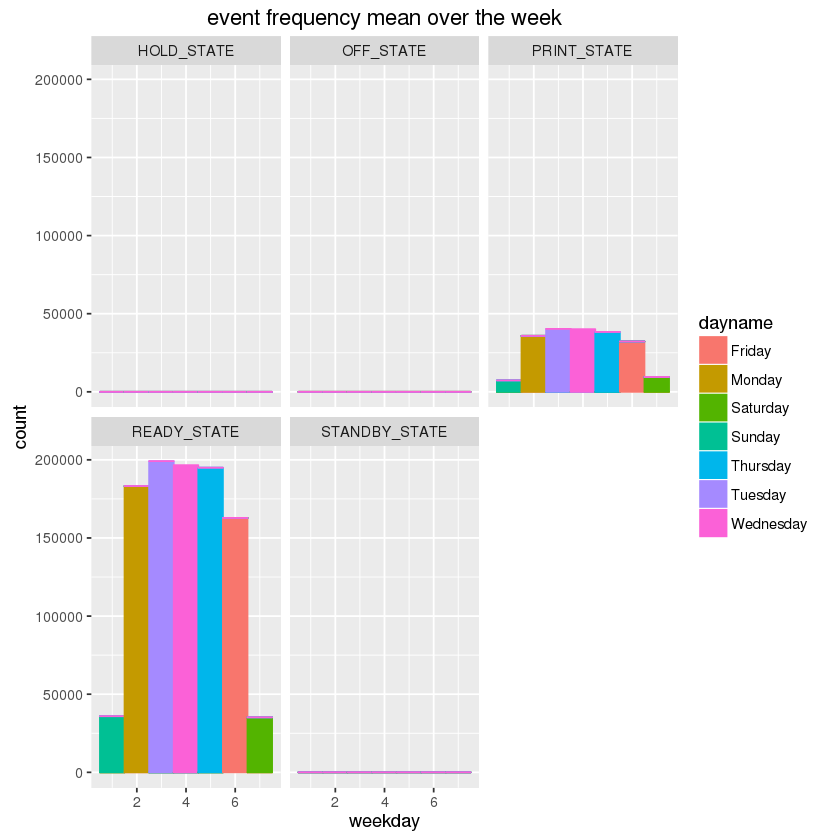

In [44]:
data %>% 
    mutate(weekday = wday(dt_event_date), dayname = weekdays(dt_event_date)) %>%
    ggplot(aes(x=weekday, y=..count.., col=dayname, fill=dayname)) +
    geom_histogram(bins = 7) +
    ggtitle("event frequency mean over the week") + 
    facet_wrap(~ event_state)

Plot shows similar distribution regardless of print_state.

## 4. Conclusions
The result from this analysis shows that the event occurrence distribution follows a similar seasonal pattern for weekdays and weekends regardless of product lines, districts, firmware versions and printer states. 

Events during weekdays are more than double compared to weekends in all plots.

This information can influence on the way machine learning models are trained considering only SAMPLE_PIP_AND_IMO_PARAMETERS. For instance by training separate models for weekdays and weekends or perhaps by discarding event occurrences weekends completely.